In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

In [3]:
DATA_DIR = '/content/gdrive/My Drive/Colab Notebooks/dl-sp-c1w4/datasets'

def reshape_input(x):
    return x

def load_data():
    import h5py
    import numpy as np
    import os

    train_path = f"{DATA_DIR}/train_catvnoncat.h5"
    test_path = f"{DATA_DIR}/test_catvnoncat.h5"

    train_dataset = h5py.File(train_path, "r")
    train_set_x_orig = torch.from_numpy(np.array(train_dataset["train_set_x"][:])).float()
    train_set_x = reshape_input(train_set_x_orig)
    train_set_y = torch.from_numpy(np.array(train_dataset["train_set_y"][:])).float()

    test_dataset = h5py.File(test_path, "r")
    test_set_x_orig = torch.from_numpy(np.array(test_dataset["test_set_x"][:])).float()
    test_set_x = reshape_input(test_set_x_orig)
    test_set_y = torch.from_numpy(np.array(test_dataset["test_set_y"][:])).float()

    classes = test_dataset["list_classes"][:]
    classes = [x.decode('utf-8') for x in classes]

    return train_set_x, train_set_y, test_set_x, test_set_y, classes

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
print(f"{train_x_orig.shape=}")
print(f"{train_y.shape=}")
print(f"{test_x_orig.shape=}")
print(f"{test_y.shape=}")

train_x_orig.shape=torch.Size([209, 64, 64, 3])
train_y.shape=torch.Size([209])
test_x_orig.shape=torch.Size([50, 64, 64, 3])
test_y.shape=torch.Size([50])


In [34]:
class Model:
    def predict(self, x):
        for layer in self.layers:
            layer.training = False

        with torch.no_grad():
            y_pred = self(x)
            y_pred = (y_pred > 0.5).float()
        return y_pred

    @staticmethod
    def accuracy(y_pred, y_true):
        return (y_pred == y_true).float().mean()

    @staticmethod
    def confustion_matrix(y_pred, y_true):
        cm = confusion_matrix(y_true, y_pred)
        print(cm)
        ConfusionMatrixDisplay(cm).plot()


class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __repr__(self):
    return f"{self.__class__.__name__}({self.n})"

  def __call__(self, x):
    exmps, rows, values = x.shape
    x = x.view(exmps, rows//self.n, values*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []


class Linear:

  def __init__(self, fan_in, fan_out, bias=True, id="id"):
    self.id = id
    self.f_in, self.f_out = fan_in, fan_out
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __repr__(self):
    return f"[{self.id}]{self.__class__.__name__} [{self.f_in}->{self.f_out}]"

  def __call__(self, x):
    # print(str(self), f"{x.shape=}")
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    self.out = self.out.squeeze()
    # print(str(self), f"{self.out.shape=}")
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class LeakyRelu:

  def __init__(self):
    self.relu = torch.nn.LeakyReLU()

  def __call__(self, x):
    self.out = self.relu(x)
    return self.out

  def parameters(self):
    return []

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
    self._parameters = [self.gamma, self.beta]

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      dim = tuple(range(x.ndim-1))
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return self._parameters


class WaveStack:

  def __init__(self, fan_in:int, dim_in:int, neurons=10, activationLayer=LeakyRelu):
    assert dim_in & (dim_in - 1) == 0

    layers = []
    id = 0
    while dim_in > 1:
        layers.extend([FlattenConsecutive(2), Linear(fan_in*2, neurons, bias=False, id=id), BatchNorm1d(neurons), activationLayer()])
        dim_in //= 2
        fan_in = neurons
        id += 1
    self.layers = layers
    self._parameters = [p for layer in self.layers for p in layer.parameters()]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return self._parameters


class LinearStack:

  def __init__(self, fan_in:int, layer_dims:list[int], activationLayer=LeakyRelu):
    layers = [Linear(fan_in, layer_dims[0], bias=False), BatchNorm1d(layer_dims[0]), activationLayer()]
    for i in range(1, len(layer_dims)):
      layer_fan_in, layer_fan_out = layer_dims[i-1], layer_dims[i]
      layers.append(Linear(layer_fan_in, layer_fan_out))

      # Try commenting this line out and see the mindf*** which happens
      # I literally had to go and see the distribution of `out` of each layer to understand what could be going wrong
      layers.append(BatchNorm1d(layer_fan_out))

      layers.append(activationLayer())
    self.layers = layers
    self._parameters = [p for layer in layers for p in layer.parameters()]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return self._parameters


class Sigmoid:

  def __call__(self, x):
    self.out = torch.sigmoid(x)
    return self.out

  def parameters(self):
    return []


class Sequential(Model):

  def __init__(self, layers):
    self.layers = []
    for layer in layers:
        if hasattr(layer, 'layers'):
            self.layers.extend(layer.layers)
        else:
            self.layers.append(layer)
    self._parameters = [p for layer in self.layers for p in layer.parameters()]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return self._parameters

In [35]:
def wave_model(n_hidden=10):
    model = Sequential([
                Linear(3, 1, bias=False), BatchNorm1d(1), LeakyRelu(),
                WaveStack(train_x_orig.shape[2], train_x_orig.shape[1], neurons=n_hidden, activationLayer=LeakyRelu),
                Linear(n_hidden, 1), Sigmoid(),
            ])

    # parameter init
    with torch.no_grad():
        model.layers[-2].weight *= 0.1 # last layer make less confident

    parameters = model.parameters()

    for p in parameters:
        p.requires_grad = True

    return model, sum(p.nelement() for p in parameters)

In [66]:
model, nparameters = wave_model(n_hidden=5)
print(f"{nparameters=}")
model.layers

nparameters=961


[[id]Linear [3->1],
 FlattenConsecutive(2),
 [0]Linear [128->5],
 FlattenConsecutive(2),
 [1]Linear [10->5],
 FlattenConsecutive(2),
 [2]Linear [10->5],
 FlattenConsecutive(2),
 [3]Linear [10->5],
 FlattenConsecutive(2),
 [4]Linear [10->5],
 FlattenConsecutive(2),
 [5]Linear [10->5],
 [id]Linear [5->1],

Iteration 1 | Loss: 0.7356769442558289
Iteration 101 | Loss: 0.6155809164047241
Iteration 201 | Loss: 0.6094621419906616
Iteration 301 | Loss: 0.6803346276283264
Iteration 401 | Loss: 0.5642908811569214
Iteration 501 | Loss: 0.5735829472541809
Iteration 601 | Loss: 0.5654395818710327
Iteration 701 | Loss: 0.8689063191413879
Iteration 801 | Loss: 0.49889108538627625
Iteration 901 | Loss: 0.4585898220539093
Iteration 1001 | Loss: 0.47318360209465027
Iteration 1101 | Loss: 0.43783140182495117
Iteration 1201 | Loss: 0.4249947667121887
Iteration 1301 | Loss: 0.37202003598213196
Iteration 1401 | Loss: 0.6680999398231506
Iteration 1501 | Loss: 0.8439942002296448
Iteration 1601 | Loss: 0.39675378799438477
Iteration 1701 | Loss: 0.3390934467315674
Iteration 1801 | Loss: 0.4181625545024872
Iteration 1901 | Loss: 0.9074663519859314
Iteration 2001 | Loss: 0.4594392776489258
Iteration 2101 | Loss: 0.27203893661499023
Iteration 2201 | Loss: 0.2509353458881378
Iteration 2301 | Loss: 0.380079627037048

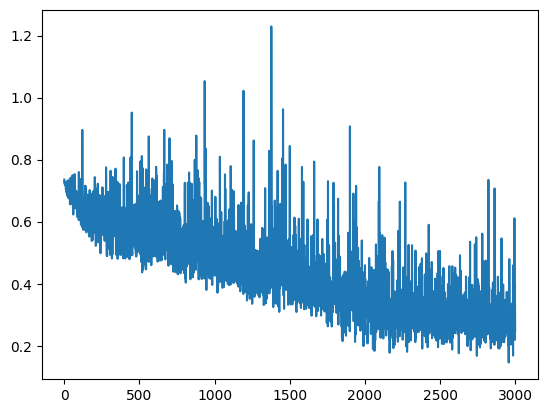

In [67]:
def learning_rate(iteration:int, total_iterations:int, lr=0.01, decay_after=0.8, decay_amount=0.1):
    return (lr * decay_amount) if iteration > (decay_after * total_iterations) else lr

def prepare_batch(X, Y, batch_size):
    idx = torch.randperm(X.shape[0])[:batch_size]
    return X[idx], Y[idx]

def train(model, X, Y, lr = 0.02, batch_size=16, num_iterations=3000, weight_decay=0.0):

    for layer in model.layers:
        layer.training = True

    losses = []
    loss_fn = torch.nn.BCELoss()

    decay_after = 0.7 # decay after decay_after% iterations are done

    for i in range(0, num_iterations):

        # Batch data preparation
        batch_x, batch_y = prepare_batch(X, Y, batch_size)

        # Forward propagation:
        batch_y_pred = model(batch_x)
        loss = loss_fn(batch_y_pred, batch_y)

        # L2 Regularization
        if weight_decay > 0:
            # Only regularize weights (tensors with 2+ dimensions), not biases or batchnorm params.
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters() if p.dim() > 1)
            loss = loss + weight_decay * l2_norm

        # backward pass
        for p in model.parameters():
            p.grad = None
        loss.backward()

        # update: simple SGD
        for p in model.parameters():
            p.data += -learning_rate(i, num_iterations, lr, decay_after) * p.grad

        if (i % 100 == 0) or (i == num_iterations - 1):
            print(f"Iteration {i+1} | Loss: {loss.item()}")

        losses.append(loss.item())

        # break

    return losses

losses = train(model, train_x_orig, train_y, weight_decay=0.001)
plt.plot(torch.tensor(losses))

train accuracy: 0.9138755798339844
test accuracy: 0.8199999928474426
[[13  4]
 [ 5 28]]


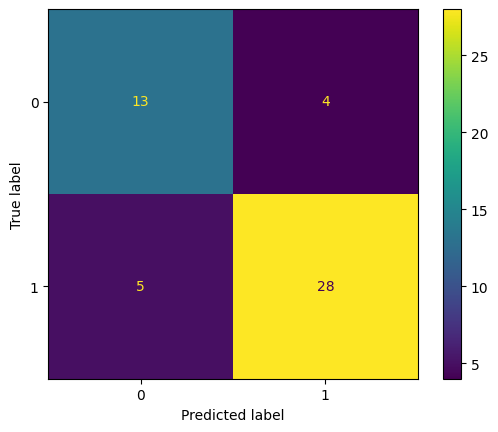

In [68]:
prediction_model = model

predictions_train = prediction_model.predict(train_x_orig)
train_accuracy = Model.accuracy(predictions_train, train_y)

predictions_test = prediction_model.predict(test_x_orig)
test_accuracy = Model.accuracy(predictions_test, test_y)

print(f"train accuracy: {train_accuracy}")
print(f"test accuracy: {test_accuracy}")

# Model.confustion_matrix(predictions_train, train_y)
Model.confustion_matrix(predictions_test, test_y)

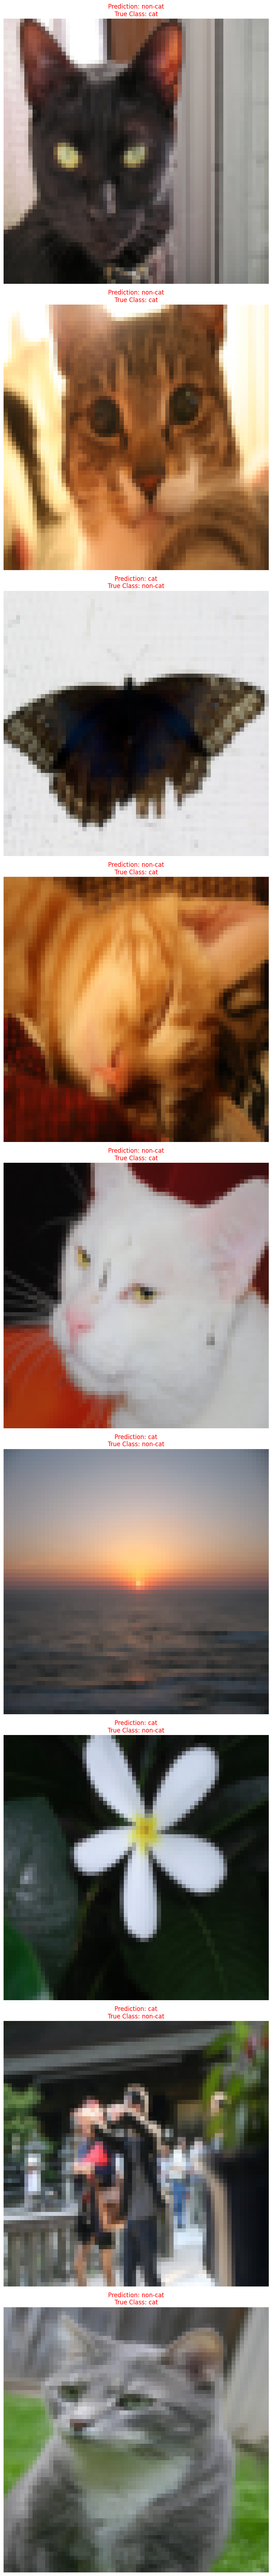

In [76]:
import matplotlib.pyplot as plt

def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.

    Args:
        classes (list): A list of class names.
        X (torch.Tensor): The dataset with shape (num_examples, height, width, channels).
        y (torch.Tensor): True labels with shape (num_examples,).
        p (torch.Tensor): Predictions with shape (num_examples,).
    """
    # Find indices where predictions and true labels don't match
    mislabeled_indices = torch.where(p != y)[0]

    num_images = len(mislabeled_indices)
    if num_images == 0:
        print("No mislabeled images to display. The model is perfect on this batch! 🎉")
        return

    # Set up the plot for displaying images
    plt.rcParams['figure.figsize'] = (10, 10 * (num_images / 5 + 1))  # Adjust figure size dynamically

    # Use subplots to create a grid of images
    fig, axes = plt.subplots(num_images, 1, figsize=(8, 8 * num_images))
    if num_images == 1:
        axes = [axes] # Ensure axes is an iterable even for a single image

    for i, index in enumerate(mislabeled_indices):
        # Extract the image from the tensor and convert to a NumPy array for plotting
        image = X[index].cpu().numpy().astype(int)

        # Plot the image on the corresponding subplot axis
        axes[i].imshow(image)
        axes[i].axis('off')

        # Get the predicted and true class names
        predicted_class = classes[int(p[index])]
        true_class = classes[int(y[index])]

        # Set the title with prediction and true label
        axes[i].set_title(f"Prediction: {predicted_class}\nTrue Class: {true_class}", color='red')

    plt.tight_layout()
    plt.show()

print_mislabeled_images(classes, test_x_orig, test_y, predictions_test)

y = 1.0, your model predicts a "cat" picture.


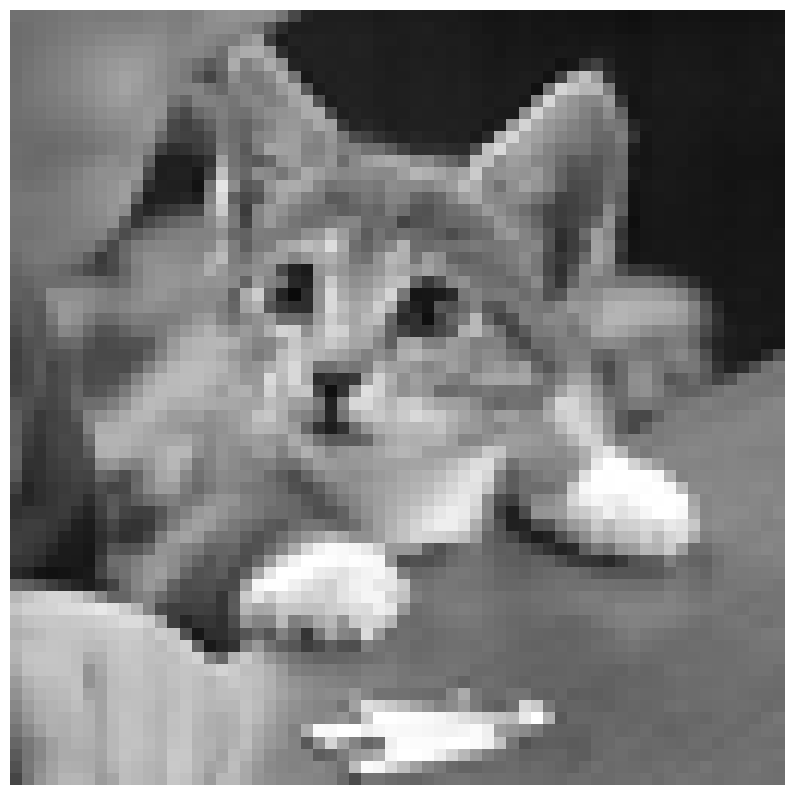

In [81]:
from PIL import Image
import matplotlib.pyplot as plt

def predict_single_image(image_path, classes, predict_fn, num_px=64):
    """
    Loads, preprocesses, and predicts the class of a single image using a PyTorch model.
    """
    try:
        fileImage = Image.open(image_path).convert("RGB").resize((num_px, num_px), Image.LANCZOS)

        image_tensor = torch.tensor(list(fileImage.getdata()), dtype=torch.float32).reshape(1, num_px, num_px, 3)

    except FileNotFoundError:
        print(f"Error: The image file '{image_path}' was not found.")
        return
    except Exception as e:
        print(f"An error occurred during image processing: {e}")
        return

    my_label_y = torch.tensor([1], dtype=torch.float)

    my_predicted_image = predict_fn(image_tensor)

    image_to_plot = fileImage.resize((num_px, num_px), Image.LANCZOS)

    # Plot the image and print the prediction
    plt.imshow(image_to_plot)
    plt.axis('off')

    # Squeeze the tensor to get the scalar prediction value
    predicted_value = my_predicted_image.squeeze().item()

    predicted_class_name = classes[int(predicted_value)]

    print(f"y = {predicted_value}, your model predicts a \"{predicted_class_name}\" picture.")

tst_img = f"{DATA_DIR}/tst_img1.jpg"
predict_single_image(tst_img, classes, prediction_model.predict)